## Library

In [69]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from copy import copy
from scipy import stats

exec(open('library.py').read())
print('Loaded')

Loaded
Loaded


## Variables (customize these)

In [70]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
USE_NUMBERS = 'Peter'                             # Which variable set (see below) to use?
GRAPH_P = 50                                      # What percentile to graph on the graphs below? (default: 50)
initial_gdp = 21 * trillion                       # GDP in `CURRENT_YEAR` of country that will develop TAI (default: 21.3 trillion)


# Variable sets - definitely change these!
if USE_NUMBERS == 'Ajeya':
    tai_flop_size = lognorm(27.58, 46.29)          # 90% CI, it takes 10^FLOPs to run a transformative AI at inference. Take 10^13-17 from Carlsmith report and add 1 OOM due to algorithmic inefficiency.
                                                   # Note: A petaflop/s-day (pfs-day) consists of performing 10^15 neural net operations per second for one day, or a total of about 10^20 operations
    algo_doubling_rate = norm(2.5, 2.5)            # 90% CI, algorithms get twice as efficient every X years
    min_reduction = norm(2, 2)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(5, 5)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17.2, 17.2)    # 90% CI, as of today, we can buy 10^X FLOPs per $
    flops_halving_rate = norm(2.6, 3)              # 90% CI, the cost of FLOPs per $ halves every X years
    max_flops_per_dollar = norm(24, 24)            # 90% CI, the cheapest FLOPs will get is 10^X FLOPs per $
    initial_pay = norm(8.7, 8.7)                   # 90% CI, as of today the maximum we would pay for TAI is $10^X
    gdp_growth = norm(1.03, 1.03)                  # 90% CI, GDP will increase by a factor of X each year
    max_gdp_frac = norm(0.01, 0.01)                # 90% CI, the maximum % of GDP that would be spent on TAI is $10^X
    willingness_ramp = norm(1, 1)                  # 90% CI, if we are X% of the spend needed to acheive TAI, we will instantly jump to TAI
    spend_doubling_time = norm(2.5, 2.5)           # 90% CI, our willingness to spend on TAI doubles every X years
    initial_chance_of_nonscaling_issue = 0         # What is the chance there will be a non-scaling issue if TAI is feasible in `CURRENT_YEAR`?
    final_chance_of_nonscaling_issue = 0           # What is the chance there will be a non-scaling issue if TAI is feasible only by `nonscaling_issue_bottom_year` (see below)?
    nonscaling_issue_bottom_year = 0               # What year will will the chance of a non-scaling issue bottom out at (reaching `final_chance_of_nonscaling_issue`)?
    nonscaling_delay = norm(0, 0)                  # 90% CI, conditional on a delay, how many additional years will TAI be delayed due to issues unrelated to scaling to an adequate number of FLOPs (e.g., collecting the relevant training data)?
    base_p_recursive = 0                           # We assume the likelihood of seeing some recursive self-improvement loop increases as we get closer to TAI-level. What is the probability of such a loop at the max?
    recursive_curve_steepness = 0                  # How steep does the probability of recursive self-improvement increase with an increased amount of FLOP relative to the FLOP needed for TAI?
    recursive_curve_inflection = 0                 # How early in the ratio of FLOP present to FLOP needed for TAI does recursive self-improvement start (defining logistic curve)?
    p_recursive_creates_tai_instantly = 0          # If a recursive self-improvement loop is initiated, how likely is it to create full TAI within the year?
    recursive_flops_halving_rate_ = None           # If a recursive self-improvement loop is initiated, what does the FLOP halving rate become? (Assume now AI are potentially designing chips)
    recursive_algo_doubling_rate_ = None           # If a recursive self-improvement loop is initiated, what does the algorithm doubling rate become? (Assume now AI are potentially designing algorithms)
    recursive_spend_doubling_time = None           # If a recursive self-improvement loop is initiated, what does our spend doubling time become? (Assume now AIs can potntailly design profitable products) 
    recursive_gdp_growth_ = None                   # If a recursive self-improvement loop is initiated, what does our GDP growth rate become? (Assume now AIs can potntailly design profitable products)
    recursive_initial_chance_of_nonscaling_issue = None  # If a recursive self-improvement loop is initiated, what does `initial_chance_of_nonscaling_issue` become? (Assume now AIs can try to solve scaling issues)
    recursive_final_chance_of_nonscaling_issue = None    # If a recursive self-improvement loop is initiated, what does `final_chance_of_nonscaling_issue` become? (Assume now AIs can try to solve scaling issues)

elif USE_NUMBERS == 'Peter':
    tai_flop_size = lognorm(26, 46)
    algo_doubling_rate = norm_lclip(1, 5)
    min_reduction = norm(1, 3)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(4, 8)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17, 17.5)      # More increase in compute, plus possibilities that big companies have found some additional initial efficiency.
    flops_halving_rate = norm(2, 4)
    max_flops_per_dollar = norm(22, 27)            # Added uncertainty around fundamental limits
    initial_pay = norm(7, 8)                       # Minimum of $10M since that has already happened. Uncertain of how much we could be paying privately.
    gdp_growth = norm(1.015, 1.03)                 # Added uncertainty around potential GDP slowdown
    max_gdp_frac = lognorm_lclip(0.0015, 0.02)     # Added uncertainty around how much of GDP we'd be willing to spend
    willingness_ramp = norm(0.7, 1)
    spend_doubling_time = lognorm_lclip(0.5, 3)    # Added uncertainty around how fast spending will accelerate
    initial_chance_of_nonscaling_issue = 0.9
    final_chance_of_nonscaling_issue = 0.1
    nonscaling_issue_bottom_year = 2060
    nonscaling_delay = lognorm(1, 20)
    base_p_recursive = 0.5
    recursive_curve_steepness = 35
    recursive_curve_inflection = 0.1
    p_recursive_creates_tai_instantly = 0.05
    recursive_flops_halving_rate = lognorm_lclip(0.3, 2)
    recursive_algo_doubling_rate = lognorm_lclip(0.3, 2)
    recursive_spend_doubling_time = lognorm_lclip(0.3, 2)
    recursive_gdp_growth = lognorm_lclip(1.02, 1.1)
    recursive_initial_chance_of_nonscaling_issue = 0.2
    recursive_final_chance_of_nonscaling_issue = 0.01
    
else:
    raise ValueError


# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)

def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 709:
        return 10 ** (math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)

def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)

def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=0.01,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def p_nonscaling_delay(initial_p, final_p, year, max_year):
    initial_p = initial_p - final_p
    p_ = initial_p - (initial_p * ((year - CURRENT_YEAR) / (max_year - CURRENT_YEAR))) + final_p
    return final_p if p_ < final_p else p_

def p_rapid_recursive_self_improvement(flops_needed_for_tai, flops_we_have, base_p, curve_steepness, curve_inflection):
    if flops_we_have > 10 ** 250:
        return base_p  # Handle overflow error
    else:
        ratio = flops_we_have / flops_needed_for_tai
        return base_p / (1 + math.exp(-curve_steepness * (ratio - curve_inflection)))

    
# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
print('Loaded')


Loaded


In [71]:
initial_flops_p = get_percentiles([sample(tai_flop_size) for s in range(1000)], reverse=True)
initial_flops_p

{95: 26.017498045859565,
 90: 27.909967651766454,
 80: 30.207043972512736,
 70: 31.79996465935033,
 60: 33.2874759151133,
 50: 34.69794103348943,
 40: 36.57887839959966,
 30: 38.26699103233113,
 20: 40.41513136619526,
 10: 43.54624129991356,
 5: 46.72790845062091}

In [72]:
min_reduction_p = get_percentiles([sample(min_reduction) for s in range(1000)], reverse=True)
min_reduction_p

{95: 0.9764508484107424,
 90: 1.1834946535526352,
 80: 1.4604478624441621,
 70: 1.6790434588138385,
 60: 1.8528529223297616,
 50: 2.002307196321108,
 40: 2.157975282274041,
 30: 2.302981459294818,
 20: 2.470747011958566,
 10: 2.737743986667867,
 5: 2.9799437161724893}

In [73]:
max_reduction_p = get_percentiles([sample(max_reduction) for s in range(1000)], reverse=True)
max_reduction_p

{95: 3.890489143551745,
 90: 4.511589555975356,
 80: 4.994840403219605,
 70: 5.345521465277869,
 60: 5.662032487038298,
 50: 5.930516811129128,
 40: 6.217227648160399,
 30: 6.559437865409837,
 20: 6.98520324427911,
 10: 7.535899595510091,
 5: 7.908074476174652}

In [74]:
algo_doubling_rate_p = get_percentiles([sample(algo_doubling_rate) for s in range(1000)], reverse=True)
algo_doubling_rate_p

{95: 1.0,
 90: 1.3582547350468863,
 80: 1.9081853028856286,
 70: 2.3102415330058,
 60: 2.6198742251284477,
 50: 2.868958579545678,
 40: 3.225735315591712,
 30: 3.602949856938375,
 20: 3.977552440219747,
 10: 4.481923476678894,
 5: 4.984715498464024}

In [75]:
initial_flops_per_dollar_p = get_percentiles([sample(initial_flops_per_dollar) for s in range(1000)])
initial_flops_per_dollar_p

{5: 16.99177566565048,
 10: 17.05017265668785,
 20: 17.119618753157955,
 30: 17.17140807873581,
 40: 17.214323231983332,
 50: 17.25345453774854,
 60: 17.28759119489966,
 70: 17.32697092015809,
 80: 17.37880590578179,
 90: 17.447213650217655,
 95: 17.507226072876204}

In [76]:
flops_halving_rate_p = get_percentiles([sample(flops_halving_rate) for s in range(1000)], reverse=True)
flops_halving_rate_p

{95: 1.988371754295819,
 90: 2.2224955702831632,
 80: 2.512550126801982,
 70: 2.689173509314304,
 60: 2.8396153788209455,
 50: 3.007202963151388,
 40: 3.1598200020325833,
 30: 3.3422696028935905,
 20: 3.54074587940314,
 10: 3.7810823645027356,
 5: 4.011197542371599}

In [77]:
max_flops_per_dollar_p = get_percentiles([sample(max_flops_per_dollar) for s in range(1000)])
max_flops_per_dollar_p

{5: 21.93380101453815,
 10: 22.55393054473259,
 20: 23.22713107055127,
 30: 23.726356202578977,
 40: 24.105852569513875,
 50: 24.494100481807514,
 60: 24.881721866692974,
 70: 25.279577560135795,
 80: 25.72375451845767,
 90: 26.35256443873097,
 95: 26.873049630775338}

In [78]:
initial_pay_p = get_percentiles([sample(initial_pay) for s in range(1000)])
initial_pay_p

{5: 7.009809704747136,
 10: 7.125813704174518,
 20: 7.233280490076735,
 30: 7.331675898108425,
 40: 7.418495388680643,
 50: 7.488173840686132,
 60: 7.5766625711349604,
 70: 7.6587439918430915,
 80: 7.757079740562347,
 90: 7.909665002919995,
 95: 8.000558034774635}

In [79]:
gdp_growth_p = get_percentiles([sample(gdp_growth) for s in range(1000)])
gdp_growth_p

{5: 1.015037340019623,
 10: 1.0166656671705414,
 20: 1.019120770263497,
 30: 1.020307567073897,
 40: 1.0215301348054917,
 50: 1.0226191388385346,
 60: 1.023769786370346,
 70: 1.024954294676563,
 80: 1.0264612759675193,
 90: 1.02842743727808,
 95: 1.0299503687339495}

In [80]:
max_gdp_frac_p = get_percentiles([sample(max_gdp_frac) for s in range(1000)])
max_gdp_frac_p

{5: 0.0015,
 10: 0.0019006564286271955,
 20: 0.0027676910950567273,
 30: 0.0036736896307473267,
 40: 0.004443315114492553,
 50: 0.005453821397912744,
 60: 0.006765293905073529,
 70: 0.008249531586533871,
 80: 0.010438015606251965,
 90: 0.014569185454302549,
 95: 0.02014022128018903}

In [81]:
willingness_ramp_p = get_percentiles([sample(willingness_ramp) for s in range(1000)])
willingness_ramp_p

{5: 0.69942929074463,
 10: 0.7340404341247276,
 20: 0.7699251574177337,
 30: 0.796085941706828,
 40: 0.820640851374434,
 50: 0.8410234984991842,
 60: 0.8635044950818926,
 70: 0.8917828326571153,
 80: 0.9209817641417615,
 90: 0.9623108958572579,
 95: 0.9988199828903686}

In [82]:
spend_doubling_time_p = get_percentiles([sample(spend_doubling_time) for s in range(1000)], reverse=True)
spend_doubling_time_p

{95: 0.5,
 90: 0.6064305961569938,
 80: 0.7654645109428329,
 70: 0.9195045813976204,
 60: 1.083894098008448,
 50: 1.225784568338231,
 40: 1.3915976076294716,
 30: 1.616645209479229,
 20: 1.9011650300370175,
 10: 2.425031325862359,
 5: 3.0162065293300473}

In [83]:
nonscaling_delay_p = get_percentiles([sample(nonscaling_delay) for s in range(1000)], reverse=True)
nonscaling_delay_p

{95: 0.9357916445249729,
 90: 1.4096301436834247,
 80: 2.1712988417332846,
 70: 2.8590205659876258,
 60: 3.6319563981113334,
 50: 4.597085152538488,
 40: 5.5890282224725265,
 30: 7.017582097592975,
 20: 9.245188420280936,
 10: 13.093981901522694,
 5: 17.840318356854688}

In [84]:
if recursive_flops_halving_rate:
    recursive_flops_halving_rate_ = get_percentiles([sample(recursive_flops_halving_rate) for s in range(1000)])
    print(recursive_flops_halving_rate_)
else:
    print('N/A')


{5: 0.30377304298185875, 10: 0.37615599165832175, 20: 0.47990568595487343, 30: 0.5856556224016334, 40: 0.6732332047826995, 50: 0.7651628580946319, 60: 0.8875751768268352, 70: 1.0144077221373164, 80: 1.2366197189506685, 90: 1.6320748670389102, 95: 2.1533582381943144}


In [85]:
if recursive_algo_doubling_rate:
    recursive_algo_doubling_rate_ = get_percentiles([sample(recursive_algo_doubling_rate) for s in range(1000)])
    print(recursive_algo_doubling_rate_)
else:
    print('N/A')
    

{5: 0.30055979144520695, 10: 0.3775067831901816, 20: 0.4855398366212855, 30: 0.5779014017642287, 40: 0.6888827091172414, 50: 0.7907397215243702, 60: 0.8918681750546877, 70: 1.018077689549861, 80: 1.2346406427252357, 90: 1.6043264888952902, 95: 1.9339282083589175}


In [86]:
if recursive_spend_doubling_time:
    recursive_spend_doubling_time_ = get_percentiles([sample(recursive_spend_doubling_time) for s in range(1000)])
    print(recursive_spend_doubling_time_)
else:
    print('N/A')


{5: 0.30697621736523706, 10: 0.37381388514825453, 20: 0.4803338452162842, 30: 0.5687324965338257, 40: 0.658865550214926, 50: 0.7581721528371709, 60: 0.8752212816441809, 70: 0.9997339514712633, 80: 1.201121113760764, 90: 1.5416927261852202, 95: 1.9007606064211624}


In [87]:
if recursive_gdp_growth:
    recursive_gdp_growth_ = get_percentiles([sample(recursive_gdp_growth) for s in range(1000)])
    print(recursive_gdp_growth_)
else:
    print('N/A')
    

{5: 1.02, 10: 1.0269060111313988, 20: 1.0368531328774306, 30: 1.0450867693996155, 40: 1.0525046687218547, 50: 1.0594443635736202, 60: 1.0656551553320053, 70: 1.0731954796909677, 80: 1.0805209062439272, 90: 1.0912996262406973, 95: 1.102859193242543}


## GDP Over Time

Text(0, 0.5, 'log GDP')

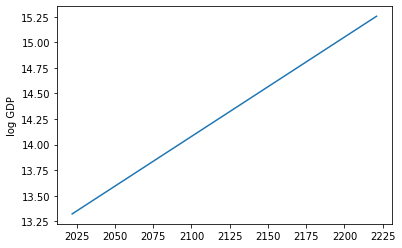

In [88]:
gdp_ = np.array([gdp(initial_gdp=initial_gdp,
                     gdp_growth=gdp_growth_p[GRAPH_P],
                     year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(gdp_))
plt.ylabel('log GDP')

In [89]:
for y in years:
    print('Year: {} - GDP log$ {} ({})'.format(y,
                                               np.round(np.log10(gdp_[y - CURRENT_YEAR]), 1),
                                               numerize(np.log10(gdp_[y - CURRENT_YEAR]))))
    

Year: 2022 - GDP log$ 13.3 (10 trillion)
Year: 2023 - GDP log$ 13.3 (10 trillion)
Year: 2024 - GDP log$ 13.3 (10 trillion)
Year: 2025 - GDP log$ 13.4 (10 trillion)
Year: 2026 - GDP log$ 13.4 (10 trillion)
Year: 2027 - GDP log$ 13.4 (10 trillion)
Year: 2028 - GDP log$ 13.4 (10 trillion)
Year: 2029 - GDP log$ 13.4 (10 trillion)
Year: 2030 - GDP log$ 13.4 (10 trillion)
Year: 2031 - GDP log$ 13.4 (10 trillion)
Year: 2032 - GDP log$ 13.4 (10 trillion)
Year: 2033 - GDP log$ 13.4 (10 trillion)
Year: 2034 - GDP log$ 13.4 (10 trillion)
Year: 2035 - GDP log$ 13.4 (10 trillion)
Year: 2036 - GDP log$ 13.5 (10 trillion)
Year: 2037 - GDP log$ 13.5 (10 trillion)
Year: 2038 - GDP log$ 13.5 (10 trillion)
Year: 2039 - GDP log$ 13.5 (10 trillion)
Year: 2040 - GDP log$ 13.5 (10 trillion)
Year: 2041 - GDP log$ 13.5 (10 trillion)
Year: 2042 - GDP log$ 13.5 (10 trillion)
Year: 2043 - GDP log$ 13.5 (10 trillion)
Year: 2044 - GDP log$ 13.5 (10 trillion)
Year: 2045 - GDP log$ 13.5 (10 trillion)
Year: 2046 - GDP

## Willingness to Pay Over Time

Text(0, 0.5, 'log $ willing to spend on TAI')

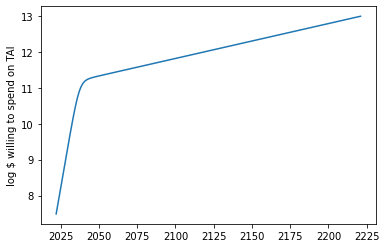

In [90]:
willingness = np.array([willingness_to_pay(initial_gdp=initial_gdp,
                                           gdp_growth=gdp_growth_p[GRAPH_P],
                                           initial_pay=10 ** initial_pay_p[GRAPH_P],
                                           spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                           max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                           year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(willingness))
plt.ylabel('log $ willing to spend on TAI')


In [91]:
for y in years:
    print('Year: {} - willingness log$ {} ({})'.format(y,
                                                       np.round(np.log10(willingness[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(willingness[y - CURRENT_YEAR]))))

Year: 2022 - willingness log$ 7.5 (10 million)
Year: 2023 - willingness log$ 7.7 (10 million)
Year: 2024 - willingness log$ 8.0 (10 million)
Year: 2025 - willingness log$ 8.2 (100 million)
Year: 2026 - willingness log$ 8.5 (100 million)
Year: 2027 - willingness log$ 8.7 (100 million)
Year: 2028 - willingness log$ 9.0 (100 million)
Year: 2029 - willingness log$ 9.2 (one billion)
Year: 2030 - willingness log$ 9.4 (one billion)
Year: 2031 - willingness log$ 9.7 (one billion)
Year: 2032 - willingness log$ 9.9 (one billion)
Year: 2033 - willingness log$ 10.1 (10 billion)
Year: 2034 - willingness log$ 10.4 (10 billion)
Year: 2035 - willingness log$ 10.6 (10 billion)
Year: 2036 - willingness log$ 10.7 (10 billion)
Year: 2037 - willingness log$ 10.9 (10 billion)
Year: 2038 - willingness log$ 11.0 (100 billion)
Year: 2039 - willingness log$ 11.1 (100 billion)
Year: 2040 - willingness log$ 11.2 (100 billion)
Year: 2041 - willingness log$ 11.2 (100 billion)
Year: 2042 - willingness log$ 11.2 (100

## FLOPs Needed to Make TAI (Given Algorithmic Progress)

Text(0, 0.5, 'log FLOPs needed to make TAI')

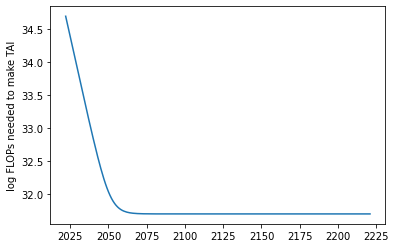

In [92]:
flops_ = np.array([flops_needed(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_))
plt.ylabel('log FLOPs needed to make TAI')


In [93]:
for y in years:
    print('Year: {} - log FLOPs needed for TAI {} ({})'.format(y,
                                                               np.round(np.log10(flops_[y - CURRENT_YEAR]), 1),
                                                               numerize(np.log10(flops_[y - CURRENT_YEAR]))))

Year: 2022 - log FLOPs needed for TAI 34.7 (10 decillion)
Year: 2023 - log FLOPs needed for TAI 34.6 (10 decillion)
Year: 2024 - log FLOPs needed for TAI 34.5 (10 decillion)
Year: 2025 - log FLOPs needed for TAI 34.4 (10 decillion)
Year: 2026 - log FLOPs needed for TAI 34.3 (10 decillion)
Year: 2027 - log FLOPs needed for TAI 34.2 (10 decillion)
Year: 2028 - log FLOPs needed for TAI 34.1 (10 decillion)
Year: 2029 - log FLOPs needed for TAI 34.0 (one decillion)
Year: 2030 - log FLOPs needed for TAI 33.9 (one decillion)
Year: 2031 - log FLOPs needed for TAI 33.8 (one decillion)
Year: 2032 - log FLOPs needed for TAI 33.7 (one decillion)
Year: 2033 - log FLOPs needed for TAI 33.5 (one decillion)
Year: 2034 - log FLOPs needed for TAI 33.4 (one decillion)
Year: 2035 - log FLOPs needed for TAI 33.3 (one decillion)
Year: 2036 - log FLOPs needed for TAI 33.2 (one decillion)
Year: 2037 - log FLOPs needed for TAI 33.1 (one decillion)
Year: 2038 - log FLOPs needed for TAI 33.0 (one decillion)
Year

## FLOPs per Dollar (Given Declining Costs)

Text(0, 0.5, 'log FLOPs per $1')

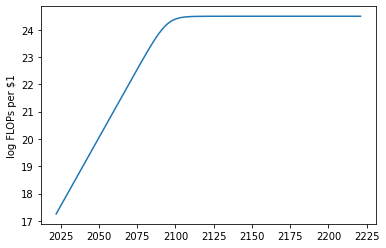

In [94]:
flops_per_dollar_ = np.array([flops_per_dollar(initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                               max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                               halving_rate=flops_halving_rate_p[GRAPH_P],
                                               year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(flops_per_dollar_))
plt.ylabel('log FLOPs per $1')


In [95]:
for y in years:
    print('Year: {} - log {} FLOPs per $ ({})'.format(y,
                                                      np.round(np.log10(flops_per_dollar_[y - CURRENT_YEAR]), 1),
                                                      numerize(np.log10(flops_per_dollar_[y - CURRENT_YEAR]))))

Year: 2022 - log 17.3 FLOPs per $ (100 quadrillion)
Year: 2023 - log 17.4 FLOPs per $ (100 quadrillion)
Year: 2024 - log 17.5 FLOPs per $ (100 quadrillion)
Year: 2025 - log 17.6 FLOPs per $ (100 quadrillion)
Year: 2026 - log 17.7 FLOPs per $ (100 quadrillion)
Year: 2027 - log 17.8 FLOPs per $ (100 quadrillion)
Year: 2028 - log 17.9 FLOPs per $ (100 quadrillion)
Year: 2029 - log 18.0 FLOPs per $ (100 quadrillion)
Year: 2030 - log 18.1 FLOPs per $ (one quintillion)
Year: 2031 - log 18.2 FLOPs per $ (one quintillion)
Year: 2032 - log 18.3 FLOPs per $ (one quintillion)
Year: 2033 - log 18.4 FLOPs per $ (one quintillion)
Year: 2034 - log 18.5 FLOPs per $ (one quintillion)
Year: 2035 - log 18.6 FLOPs per $ (one quintillion)
Year: 2036 - log 18.7 FLOPs per $ (one quintillion)
Year: 2037 - log 18.8 FLOPs per $ (one quintillion)
Year: 2038 - log 18.9 FLOPs per $ (one quintillion)
Year: 2039 - log 19.0 FLOPs per $ (one quintillion)
Year: 2040 - log 19.1 FLOPs per $ (10 quintillion)
Year: 2041 - 

## Max Possible OOM Reduction in TAI FLOP Size

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

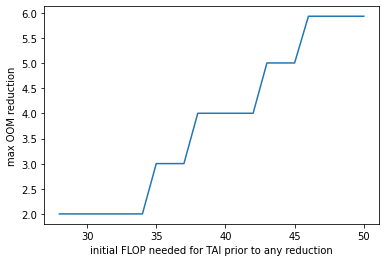

In [96]:
tai_sizes = range(28, 51)
flops_per_dollar_ = np.array([possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('max OOM reduction')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')

In [137]:
for t in tai_sizes:
    print('TAI log FLOP {} -> {} OOM reductions possible'.format(t,
                                                                 round(possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                                  max_reduction_p[GRAPH_P],
                                                                                                  t), 2))
          

SyntaxError: unexpected EOF while parsing (<ipython-input-137-0afabffbdd1c>, line 6)

## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP)

Text(0, 0.5, 'log $ needed to buy TAI')

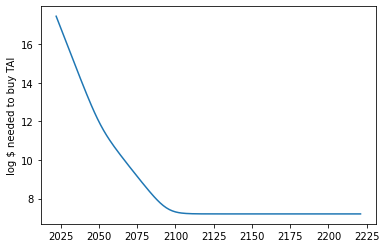

In [98]:
cost_of_tai_ = np.array([cost_of_tai(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                     possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                     algo_doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                     initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                     max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                     flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                     year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(cost_of_tai_))
plt.ylabel('log $ needed to buy TAI')


In [99]:
for y in years:
    print('Year: {} - log $ {} to buy TAI ({})'.format(y,
                                                       np.round(np.log10(cost_of_tai_[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(cost_of_tai_[y - CURRENT_YEAR]))))

Year: 2022 - log $ 17.4 to buy TAI (100 quadrillion)
Year: 2023 - log $ 17.2 to buy TAI (100 quadrillion)
Year: 2024 - log $ 17.0 to buy TAI (100 quadrillion)
Year: 2025 - log $ 16.8 to buy TAI (10 quadrillion)
Year: 2026 - log $ 16.6 to buy TAI (10 quadrillion)
Year: 2027 - log $ 16.4 to buy TAI (10 quadrillion)
Year: 2028 - log $ 16.2 to buy TAI (10 quadrillion)
Year: 2029 - log $ 16.0 to buy TAI (10 quadrillion)
Year: 2030 - log $ 15.8 to buy TAI (one quadrillion)
Year: 2031 - log $ 15.6 to buy TAI (one quadrillion)
Year: 2032 - log $ 15.4 to buy TAI (one quadrillion)
Year: 2033 - log $ 15.2 to buy TAI (one quadrillion)
Year: 2034 - log $ 15.0 to buy TAI (100 trillion)
Year: 2035 - log $ 14.8 to buy TAI (100 trillion)
Year: 2036 - log $ 14.6 to buy TAI (100 trillion)
Year: 2037 - log $ 14.4 to buy TAI (100 trillion)
Year: 2038 - log $ 14.2 to buy TAI (100 trillion)
Year: 2039 - log $ 14.0 to buy TAI (10 trillion)
Year: 2040 - log $ 13.8 to buy TAI (10 trillion)
Year: 2041 - log $ 13

## FLOPs at Max Spend

Text(0, 0.5, 'max log FLOPs bought given willingness to spend')

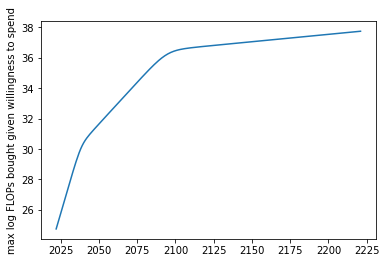

In [100]:
flops_at_max_ = np.array([flops_at_max(initial_gdp=initial_gdp,
                                       gdp_growth=gdp_growth_p[GRAPH_P],
                                       initial_pay=10 ** initial_pay_p[GRAPH_P],
                                       spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                       max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                       initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                       max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                       flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                       year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_at_max_))
plt.ylabel('max log FLOPs bought given willingness to spend')


In [101]:
for y in years:
    print('Year: {} - max log FLOPs {} ({})'.format(y,
                                                    np.round(np.log10(flops_at_max_[y - CURRENT_YEAR]), 1),
                                                    numerize(np.log10(flops_at_max_[y - CURRENT_YEAR]))))

Year: 2022 - max log FLOPs 24.7 (one septillion)
Year: 2023 - max log FLOPs 25.1 (10 septillion)
Year: 2024 - max log FLOPs 25.4 (10 septillion)
Year: 2025 - max log FLOPs 25.8 (10 septillion)
Year: 2026 - max log FLOPs 26.1 (100 septillion)
Year: 2027 - max log FLOPs 26.5 (100 septillion)
Year: 2028 - max log FLOPs 26.8 (100 septillion)
Year: 2029 - max log FLOPs 27.2 (one octillion)
Year: 2030 - max log FLOPs 27.5 (one octillion)
Year: 2031 - max log FLOPs 27.8 (one octillion)
Year: 2032 - max log FLOPs 28.2 (10 octillion)
Year: 2033 - max log FLOPs 28.5 (10 octillion)
Year: 2034 - max log FLOPs 28.8 (10 octillion)
Year: 2035 - max log FLOPs 29.2 (100 octillion)
Year: 2036 - max log FLOPs 29.5 (100 octillion)
Year: 2037 - max log FLOPs 29.7 (100 octillion)
Year: 2038 - max log FLOPs 30.0 (one nonillion)
Year: 2039 - max log FLOPs 30.2 (one nonillion)
Year: 2040 - max log FLOPs 30.4 (one nonillion)
Year: 2041 - max log FLOPs 30.6 (one nonillion)
Year: 2042 - max log FLOPs 30.7 (one no

## Chance of Non-scaling Delay

Text(0, 0.5, 'chance of non-scaling delay by year')

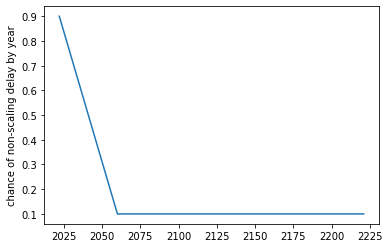

In [102]:
p_nonscaling_delay_ = np.array([p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                   final_chance_of_nonscaling_issue,
                                                   year=y,
                                                   max_year=nonscaling_issue_bottom_year) for y in years])

plt.plot(years, p_nonscaling_delay_)
plt.ylabel('chance of non-scaling delay by year')
# TODO: Make logistic?

In [103]:
for y in years:
    print('Year: {} - p(nonscaling delay) = {}%'.format(y,
                                                        np.round(p_nonscaling_delay_[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - p(nonscaling delay) = 90.0%
Year: 2023 - p(nonscaling delay) = 87.9%
Year: 2024 - p(nonscaling delay) = 85.8%
Year: 2025 - p(nonscaling delay) = 83.7%
Year: 2026 - p(nonscaling delay) = 81.6%
Year: 2027 - p(nonscaling delay) = 79.5%
Year: 2028 - p(nonscaling delay) = 77.4%
Year: 2029 - p(nonscaling delay) = 75.3%
Year: 2030 - p(nonscaling delay) = 73.2%
Year: 2031 - p(nonscaling delay) = 71.1%
Year: 2032 - p(nonscaling delay) = 68.9%
Year: 2033 - p(nonscaling delay) = 66.8%
Year: 2034 - p(nonscaling delay) = 64.7%
Year: 2035 - p(nonscaling delay) = 62.6%
Year: 2036 - p(nonscaling delay) = 60.5%
Year: 2037 - p(nonscaling delay) = 58.4%
Year: 2038 - p(nonscaling delay) = 56.3%
Year: 2039 - p(nonscaling delay) = 54.2%
Year: 2040 - p(nonscaling delay) = 52.1%
Year: 2041 - p(nonscaling delay) = 50.0%
Year: 2042 - p(nonscaling delay) = 47.9%
Year: 2043 - p(nonscaling delay) = 45.8%
Year: 2044 - p(nonscaling delay) = 43.7%
Year: 2045 - p(nonscaling delay) = 41.6%
Year: 2046 - p(n

## Chance of Rapid Recursive Self-Improvement

Text(0.5, 0, 'percentage of TAI-level FLOP')

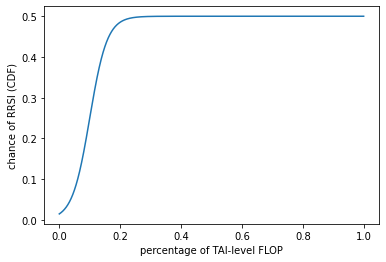

In [104]:
p_rrsi_ = np.array([p_rapid_recursive_self_improvement(10000,
                                                       x,
                                                       base_p_recursive,
                                                       recursive_curve_steepness,
                                                       recursive_curve_inflection) for x in range(10000)])

plt.plot([r / 10000 for r in range(10000)], p_rrsi_)
plt.ylabel('chance of RRSI (CDF)')
plt.xlabel('percentage of TAI-level FLOP')

In [105]:
samples = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200,
           1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
for i in samples:
    print('Ratio: {} in 10000 - p(RRSI) (CDF) = {}%'.format(i, np.round(p_rrsi_[i-1] * 100, 1)))

Ratio: 1 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 5 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 10 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 20 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 30 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 40 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 50 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 60 in 10000 - p(RRSI) (CDF) = 1.8%
Ratio: 70 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 80 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 90 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 100 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 200 in 10000 - p(RRSI) (CDF) = 2.9%
Ratio: 300 in 10000 - p(RRSI) (CDF) = 4.0%
Ratio: 400 in 10000 - p(RRSI) (CDF) = 5.4%
Ratio: 500 in 10000 - p(RRSI) (CDF) = 7.4%
Ratio: 600 in 10000 - p(RRSI) (CDF) = 9.9%
Ratio: 700 in 10000 - p(RRSI) (CDF) = 12.9%
Ratio: 800 in 10000 - p(RRSI) (CDF) = 16.6%
Ratio: 900 in 10000 - p(RRSI) (CDF) = 20.6%
Ratio: 1000 in 10000 - p(RRSI) (CDF) = 25.0%
Ratio: 1100 in 10000 - p(RRSI) (CDF) = 29.3%
Ratio: 1200 in 10000 - p(RRSI) (CDF) = 33.4%
Ratio: 1300 in 

## Run Model

Running
## RUN 1/10000 ##
Diagnostic: tai_flop_size=25.653287318755893, nonscaling_delay=3.914661244326706, algo_doubling_rate=3.8102970609157456, possible_algo_reduction=1.2137502245739644, initial_flops_per_dollar=1.7981638626059197e+17, flops_halving_rate=3.167707298461384, max_flops_per_dollar=9.601025812701698e+22, initial_pay=37255720.66513934, gdp_growth=1.0196327234479496, max_gdp_frac=0.011919689492087162, willingness_ramp=0.8641684610343174, spend_doubling_time=0.9803399398501921
-
It takes 25.7 log FLOPs (10 septillion) for transformative capabilities.
Every 3.8 years algorithms get 2x better, with 1.2 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 23.0 log FLOPs (10 sextillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 1.0x per year to a max of 0.0119% of GDP. GDP grows at a rate of 1.02x per year.
If we are 86.0% of the way to paying for TAI, we w

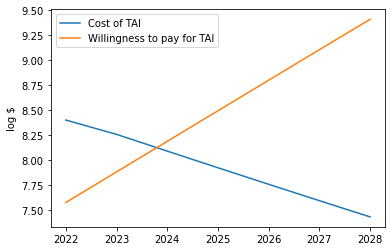

## RUN 2/10000 ##
Diagnostic: tai_flop_size=37.09871160096184, nonscaling_delay=9.862539588803086, algo_doubling_rate=3.8548958421687365, possible_algo_reduction=2.6324099931890705, initial_flops_per_dollar=2.2455572795298224e+17, flops_halving_rate=3.6531888921293456, max_flops_per_dollar=3.363891496189733e+26, initial_pay=32931201.815388326, gdp_growth=1.0168532758994855, max_gdp_frac=0.002623929159601576, willingness_ramp=0.8051470568588857, spend_doubling_time=1.3768209082640535
-
It takes 37.1 log FLOPs (10 thousand decillion) for transformative capabilities.
Every 3.9 years algorithms get 2x better, with 2.6 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.7 years they get 2x cheaper, to a maximum of 26.5 log FLOPs (100 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.4x per year to a max of 0.0026% of GDP. GDP grows at a rate of 1.017x per year.
If we are 81.0% of the way to paying for TAI, w

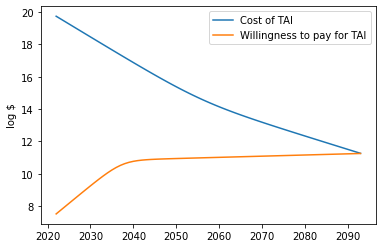

## RUN 3/10000 ##
Diagnostic: tai_flop_size=40.49957479005952, nonscaling_delay=15.324818362390356, algo_doubling_rate=1.4104773497443583, possible_algo_reduction=4.670493216002608, initial_flops_per_dollar=2.482157314517038e+17, flops_halving_rate=4.520200597768281, max_flops_per_dollar=1.4582162016832422e+24, initial_pay=33947199.55473207, gdp_growth=1.022092397384313, max_gdp_frac=0.005291353282336315, willingness_ramp=0.8621362525230168, spend_doubling_time=1.2684761236115152
-
It takes 40.5 log FLOPs (10 million decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 4.7 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 4.5 years they get 2x cheaper, to a maximum of 24.2 log FLOPs (one septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.3x per year to a max of 0.0053% of GDP. GDP grows at a rate of 1.022x per year.
If we are 86.0% of the way to paying for TAI, we wi

Year: 2043 - 30.0 max log FLOP (one nonillion) available - TAI takes 36.2 log FLOP (one thousand decillion) - log $ 17.4 to buy TAI (100 quadrillion) vs. willingness to pay log $ 11.2 (100 billion) - 18.8 log FLOPS per $ (one quintillion)
--- no rapid recursive loop (ratio=0.0, p=0.0018320520234188335, r_=0.23756588519344135)
Year: 2044 - 30.1 max log FLOP (one nonillion) available - TAI takes 36.1 log FLOP (one thousand decillion) - log $ 17.3 to buy TAI (100 quadrillion) vs. willingness to pay log $ 11.2 (100 billion) - 18.9 log FLOPS per $ (one quintillion)
--- no rapid recursive loop (ratio=0.0, p=0.001832074280817666, r_=0.6221451500271634)
Year: 2045 - 30.2 max log FLOP (one nonillion) available - TAI takes 36.0 log FLOP (one thousand decillion) - log $ 17.1 to buy TAI (100 quadrillion) vs. willingness to pay log $ 11.3 (100 billion) - 18.9 log FLOPS per $ (one quintillion)
--- no rapid recursive loop (ratio=0.0, p=0.0018321034388243639, r_=0.06770009865136961)
Year: 2046 - 30.3 

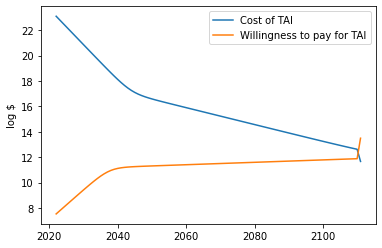

## RUN 4/10000 ##
Diagnostic: tai_flop_size=41.540229369893126, nonscaling_delay=2.6625844893474317, algo_doubling_rate=2.4777690009903877, possible_algo_reduction=4.872468238786891, initial_flops_per_dollar=2.556440922704415e+17, flops_halving_rate=2.533843422795487, max_flops_per_dollar=1.42871250184318e+25, initial_pay=26109384.16210309, gdp_growth=1.0248067182603882, max_gdp_frac=0.004482288311328521, willingness_ramp=0.7713692109323644, spend_doubling_time=1.1245467732473762
-
It takes 41.5 log FLOPs (100 million decillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 4.9 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 2.5 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 1.1x per year to a max of 0.0045% of GDP. GDP grows at a rate of 1.025x per year.
If we are 77.0% of the way to paying for TAI, we wi

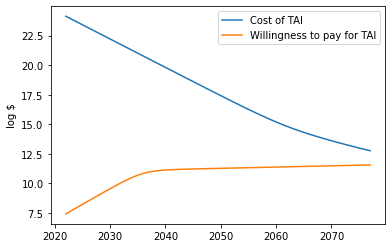

## RUN 5/10000 ##
Diagnostic: tai_flop_size=26.59987800342606, nonscaling_delay=5.9659142660342095, algo_doubling_rate=3.493231405810531, possible_algo_reduction=0.644890256198122, initial_flops_per_dollar=1.9706443280799514e+17, flops_halving_rate=2.3910368422069763, max_flops_per_dollar=5.187650183579356e+23, initial_pay=36356152.31068431, gdp_growth=1.0230679877075477, max_gdp_frac=0.005081808238957867, willingness_ramp=0.7110069748276959, spend_doubling_time=1.9477061416342298
-
It takes 26.6 log FLOPs (100 septillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 0.6 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.4 years they get 2x cheaper, to a maximum of 23.7 log FLOPs (100 sextillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 1.9x per year to a max of 0.0051% of GDP. GDP grows at a rate of 1.023x per year.
If we are 71.0% of the way to paying for TAI, we will ra

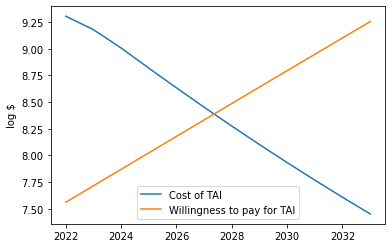

## RUN 6/10000 ##
Diagnostic: tai_flop_size=40.89234712412507, nonscaling_delay=2.2523389866317083, algo_doubling_rate=1.8786981462677301, possible_algo_reduction=3.710638550238811, initial_flops_per_dollar=2.9045549275195424e+17, flops_halving_rate=3.0241460202225663, max_flops_per_dollar=8.364192250424769e+24, initial_pay=30373787.94857137, gdp_growth=1.022953189984218, max_gdp_frac=0.007800489721567478, willingness_ramp=0.7130683753717998, spend_doubling_time=0.5
-
It takes 40.9 log FLOPs (10 million decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 3.7 log reductions possible.
FLOPs start at a cost of 17.5 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 24.9 log FLOPs (one septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.5x per year to a max of 0.0078% of GDP. GDP grows at a rate of 1.023x per year.
If we are 71.0% of the way to paying for TAI, we will ramp to pay

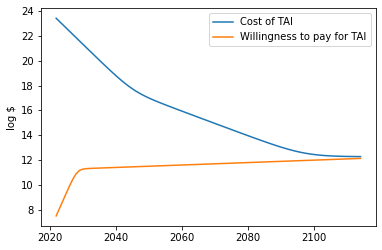

## RUN 7/10000 ##
Diagnostic: tai_flop_size=28.9966749225181, nonscaling_delay=3.8536626536358107, algo_doubling_rate=2.37054072424717, possible_algo_reduction=2.0119331468484085, initial_flops_per_dollar=1.7412265041838406e+17, flops_halving_rate=2.5859174283456428, max_flops_per_dollar=5.677813876959392e+23, initial_pay=25582826.506548814, gdp_growth=1.0258862149632657, max_gdp_frac=0.019175031309077797, willingness_ramp=0.7344130330392047, spend_doubling_time=2.3638201993260166
-
It takes 29.0 log FLOPs (10 octillion) for transformative capabilities.
Every 2.4 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.6 years they get 2x cheaper, to a maximum of 23.8 log FLOPs (100 sextillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 2.4x per year to a max of 0.0192% of GDP. GDP grows at a rate of 1.026x per year.
If we are 73.0% of the way to paying for TAI, we will ramp

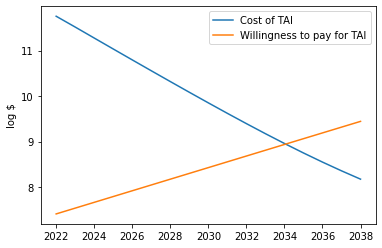

## RUN 8/10000 ##
Diagnostic: tai_flop_size=39.09727218982781, nonscaling_delay=5.951857674972816, algo_doubling_rate=2.360712500534302, possible_algo_reduction=4.839423955748915, initial_flops_per_dollar=1.2894684082647514e+17, flops_halving_rate=2.2402425396652466, max_flops_per_dollar=5.089300054203699e+25, initial_pay=19717381.204952974, gdp_growth=1.0253071539886183, max_gdp_frac=0.005186066650040591, willingness_ramp=0.7942232786014739, spend_doubling_time=1.1486361890261374
-
It takes 39.1 log FLOPs (one million decillion) for transformative capabilities.
Every 2.4 years algorithms get 2x better, with 4.8 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 2.2 years they get 2x cheaper, to a maximum of 25.7 log FLOPs (10 septillion) per $.
We are willing to pay 7.3 log $ (10 million) and this increases by 1.1x per year to a max of 0.0052% of GDP. GDP grows at a rate of 1.025x per year.
If we are 79.0% of the way to paying for TAI, we w

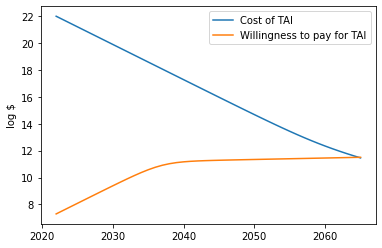

## RUN 9/10000 ##
Diagnostic: tai_flop_size=37.68447788639615, nonscaling_delay=6.776801743172801, algo_doubling_rate=1, possible_algo_reduction=3.101584227260987, initial_flops_per_dollar=7.581157036702418e+16, flops_halving_rate=1.9602391379221482, max_flops_per_dollar=4.7867321786632026e+23, initial_pay=36695610.70401121, gdp_growth=1.0212091457921952, max_gdp_frac=0.013791887483520187, willingness_ramp=0.9985411573994738, spend_doubling_time=0.5
-
It takes 37.7 log FLOPs (10 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.1 log reductions possible.
FLOPs start at a cost of 16.9 log FLOPs (10 quadrillion) per $. Every 2.0 years they get 2x cheaper, to a maximum of 23.7 log FLOPs (100 sextillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 0.5x per year to a max of 0.0138% of GDP. GDP grows at a rate of 1.021x per year.
If we are 100.0% of the way to paying for TAI, we will ramp to paying for TAI.
If a 

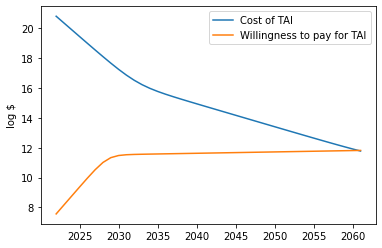

## RUN 10/10000 ##
Diagnostic: tai_flop_size=26.238816717766788, nonscaling_delay=2.3517507788194894, algo_doubling_rate=6.176958753281822, possible_algo_reduction=0.7102518492588803, initial_flops_per_dollar=2.011718525534545e+17, flops_halving_rate=2.8301196220732434, max_flops_per_dollar=5.587654629148725e+25, initial_pay=31250662.99897171, gdp_growth=1.0187648723870626, max_gdp_frac=0.0015771321396431401, willingness_ramp=0.72013089186768, spend_doubling_time=2.7248535163417325
-
It takes 26.2 log FLOPs (100 septillion) for transformative capabilities.
Every 6.2 years algorithms get 2x better, with 0.7 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.8 years they get 2x cheaper, to a maximum of 25.7 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 2.7x per year to a max of 0.0016% of GDP. GDP grows at a rate of 1.019x per year.
If we are 72.0% of the way to paying for TAI, we will ra

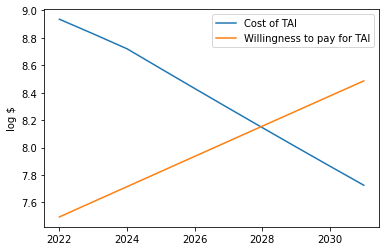

## RUN 11/10000 ##
Diagnostic: tai_flop_size=48.726582787908086, nonscaling_delay=2.6282354914968775, algo_doubling_rate=1.3743656262629786, possible_algo_reduction=5.958550847053679, initial_flops_per_dollar=9.754002301813672e+16, flops_halving_rate=3.6527124823402533, max_flops_per_dollar=4.332093696771829e+24, initial_pay=47935295.138082415, gdp_growth=1.028169239502231, max_gdp_frac=0.0027755430106412723, willingness_ramp=0.5976000450082637, spend_doubling_time=2.2691201296955894
-
It takes 48.7 log FLOPs (one quadrillion decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 6.0 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (10 quadrillion) per $. Every 3.7 years they get 2x cheaper, to a maximum of 24.6 log FLOPs (one septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 2.3x per year to a max of 0.0028% of GDP. GDP grows at a rate of 1.028x per year.
If we are 60.0% of the way to paying for TA

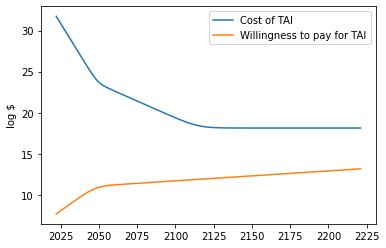

## RUN 12/10000 ##
Diagnostic: tai_flop_size=40.291387038638234, nonscaling_delay=8.589862756745093, algo_doubling_rate=3.878036520825816, possible_algo_reduction=3.8044325740764577, initial_flops_per_dollar=7.418892975813461e+16, flops_halving_rate=2.8248074606572433, max_flops_per_dollar=2.317001334502386e+25, initial_pay=50848947.59682491, gdp_growth=1.0276849458035027, max_gdp_frac=0.011738135078433362, willingness_ramp=0.7452393994444051, spend_doubling_time=0.7815501037836614
-
It takes 40.3 log FLOPs (10 million decillion) for transformative capabilities.
Every 3.9 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 16.9 log FLOPs (10 quadrillion) per $. Every 2.8 years they get 2x cheaper, to a maximum of 25.4 log FLOPs (10 septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 0.8x per year to a max of 0.0117% of GDP. GDP grows at a rate of 1.028x per year.
If we are 75.0% of the way to paying for TAI, we wi

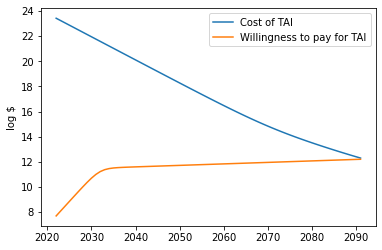

## RUN 13/10000 ##
Diagnostic: tai_flop_size=36.12782427092726, nonscaling_delay=14.29030016514191, algo_doubling_rate=1.3755211892167138, possible_algo_reduction=3.246951169714419, initial_flops_per_dollar=1.5718517067703834e+17, flops_halving_rate=3.3762786011571566, max_flops_per_dollar=3.6505227302388967e+25, initial_pay=26823512.597481184, gdp_growth=1.0256974077198, max_gdp_frac=0.009126678060382662, willingness_ramp=0.8146567911686113, spend_doubling_time=1.0935344612413689
-
It takes 36.1 log FLOPs (one thousand decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.2 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.4 years they get 2x cheaper, to a maximum of 25.6 log FLOPs (10 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 1.1x per year to a max of 0.0091% of GDP. GDP grows at a rate of 1.026x per year.
If we are 81.0% of the way to paying for TAI, we 

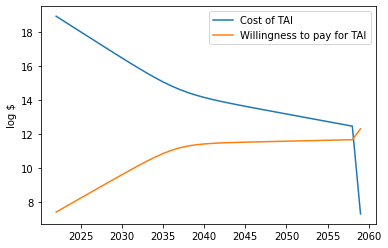

## RUN 14/10000 ##
Diagnostic: tai_flop_size=39.71816372110994, nonscaling_delay=4.199540572861156, algo_doubling_rate=2.8769029084445306, possible_algo_reduction=4.803596967347729, initial_flops_per_dollar=8.381405230411909e+16, flops_halving_rate=2.9329742787635413, max_flops_per_dollar=3.3584300798535555e+25, initial_pay=39311004.92015341, gdp_growth=1.0291928915737951, max_gdp_frac=0.005784436223035344, willingness_ramp=0.7919669914090823, spend_doubling_time=0.5
-
It takes 39.7 log FLOPs (one million decillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 4.8 log reductions possible.
FLOPs start at a cost of 16.9 log FLOPs (10 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 25.5 log FLOPs (10 septillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 0.5x per year to a max of 0.0058% of GDP. GDP grows at a rate of 1.029x per year.
If we are 79.0% of the way to paying for TAI, we will ramp to pay

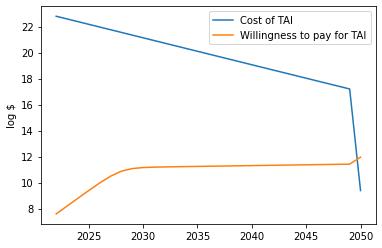

## RUN 15/10000 ##
Diagnostic: tai_flop_size=28.451531630738284, nonscaling_delay=5.290822102121957, algo_doubling_rate=2.756969060285183, possible_algo_reduction=1.0716456854665761, initial_flops_per_dollar=1.621995796245862e+17, flops_halving_rate=2.86278873568834, max_flops_per_dollar=1.6818584757172209e+25, initial_pay=30492316.026442077, gdp_growth=1.0223281962961421, max_gdp_frac=0.002339738738731678, willingness_ramp=0.6147509648268161, spend_doubling_time=1.8430677547516419
-
It takes 28.5 log FLOPs (10 octillion) for transformative capabilities.
Every 2.8 years algorithms get 2x better, with 1.1 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.8x per year to a max of 0.0023% of GDP. GDP grows at a rate of 1.022x per year.
If we are 61.0% of the way to paying for TAI, we will ramp

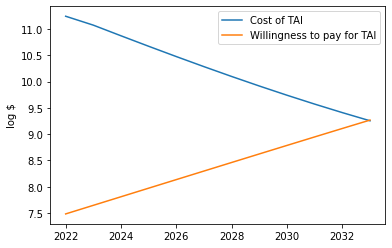

## RUN 16/10000 ##
Diagnostic: tai_flop_size=36.747936513361566, nonscaling_delay=14.291505959211017, algo_doubling_rate=1, possible_algo_reduction=2.848931433734661, initial_flops_per_dollar=2.1614966972976618e+17, flops_halving_rate=2.7375249969478377, max_flops_per_dollar=6.806973969224697e+23, initial_pay=63900884.162796594, gdp_growth=1.023354504201893, max_gdp_frac=0.0032363059661680346, willingness_ramp=0.9034191915053719, spend_doubling_time=1.0096563237287037
-
It takes 36.7 log FLOPs (one thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.7 years they get 2x cheaper, to a maximum of 23.8 log FLOPs (100 sextillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 1.0x per year to a max of 0.0032% of GDP. GDP grows at a rate of 1.023x per year.
If we are 90.0% of the way to paying for TAI, we will ramp to p

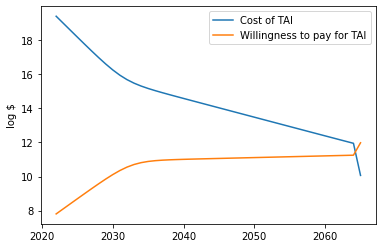

## RUN 17/10000 ##
Diagnostic: tai_flop_size=36.9644552137452, nonscaling_delay=7.733426877551032, algo_doubling_rate=1, possible_algo_reduction=2.9000338542880986, initial_flops_per_dollar=2.4590496558486714e+17, flops_halving_rate=3.3027284741124707, max_flops_per_dollar=5.596796047257475e+23, initial_pay=71223117.64014162, gdp_growth=1.0244930847579803, max_gdp_frac=0.01523410185209972, willingness_ramp=0.8759260463166071, spend_doubling_time=2.3179084036063657
-
It takes 37.0 log FLOPs (one thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 23.7 log FLOPs (100 sextillion) per $.
We are willing to pay 7.9 log $ (10 million) and this increases by 2.3x per year to a max of 0.0152% of GDP. GDP grows at a rate of 1.024x per year.
If we are 88.0% of the way to paying for TAI, we will ramp to payin

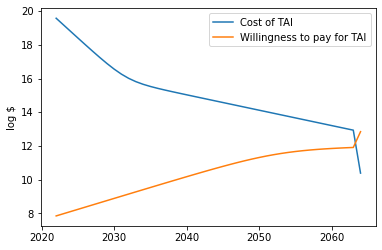

## RUN 18/10000 ##
Diagnostic: tai_flop_size=26.182494424634406, nonscaling_delay=11.91050289745492, algo_doubling_rate=1.8236740789726038, possible_algo_reduction=1.5822405605205427, initial_flops_per_dollar=1.6871542385533968e+17, flops_halving_rate=3.0889083482809463, max_flops_per_dollar=1.909777380027522e+26, initial_pay=38686872.39152677, gdp_growth=1.0255989827575172, max_gdp_frac=0.0015, willingness_ramp=0.7267513343968943, spend_doubling_time=0.5
-
It takes 26.2 log FLOPs (100 septillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.1 years they get 2x cheaper, to a maximum of 26.3 log FLOPs (100 septillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 0.5x per year to a max of 0.0015% of GDP. GDP grows at a rate of 1.026x per year.
If we are 73.0% of the way to paying for TAI, we will ramp to paying for TAI.
If a

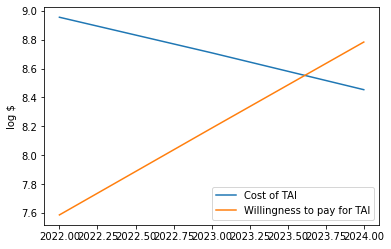

## RUN 19/10000 ##
Diagnostic: tai_flop_size=42.37472377707035, nonscaling_delay=1.8404236560022933, algo_doubling_rate=2.9270989454577925, possible_algo_reduction=5.64260773298476, initial_flops_per_dollar=1.2031280364450768e+17, flops_halving_rate=2.5243491100785937, max_flops_per_dollar=2.3342329277242707e+25, initial_pay=64685546.9001317, gdp_growth=1.0159779103349367, max_gdp_frac=0.004142180092780198, willingness_ramp=0.7567946528035838, spend_doubling_time=1.8022288698183204
-
It takes 42.4 log FLOPs (one billion decillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 5.6 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 2.5 years they get 2x cheaper, to a maximum of 25.4 log FLOPs (10 septillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 1.8x per year to a max of 0.0041% of GDP. GDP grows at a rate of 1.016x per year.
If we are 76.0% of the way to paying for TAI, we 

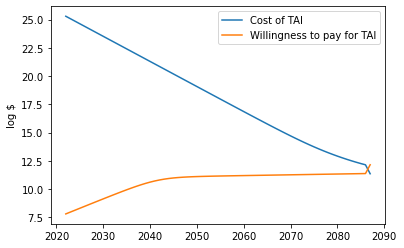

## RUN 20/10000 ##
Diagnostic: tai_flop_size=29.878855127464945, nonscaling_delay=4.703144308957767, algo_doubling_rate=3.0745156646080836, possible_algo_reduction=1.0636740517257786, initial_flops_per_dollar=1.169103666069349e+17, flops_halving_rate=2.7694427467873344, max_flops_per_dollar=1.2589975518828665e+24, initial_pay=17670251.82992914, gdp_growth=1.0196845548693843, max_gdp_frac=0.0055455255198188814, willingness_ramp=0.8824383110890718, spend_doubling_time=1.3676497399000778
-
It takes 29.9 log FLOPs (100 octillion) for transformative capabilities.
Every 3.1 years algorithms get 2x better, with 1.1 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 2.8 years they get 2x cheaper, to a maximum of 24.1 log FLOPs (one septillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 1.4x per year to a max of 0.0055% of GDP. GDP grows at a rate of 1.02x per year.
If we are 88.0% of the way to paying for TAI, we will 

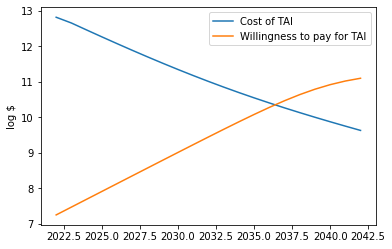

## RUN 21/10000 ##
Diagnostic: tai_flop_size=30.717676816009686, nonscaling_delay=17.843382568115153, algo_doubling_rate=3.402015004968544, possible_algo_reduction=1.0931993502880224, initial_flops_per_dollar=1.7829695704774704e+17, flops_halving_rate=2.9861626107214314, max_flops_per_dollar=1.5700483727268522e+25, initial_pay=56614143.41543316, gdp_growth=1.0181286445972637, max_gdp_frac=0.006712177446832516, willingness_ramp=0.9978864949393853, spend_doubling_time=2.113272221249063
-
It takes 30.7 log FLOPs (one nonillion) for transformative capabilities.
Every 3.4 years algorithms get 2x better, with 1.1 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 2.1x per year to a max of 0.0067% of GDP. GDP grows at a rate of 1.018x per year.
If we are 100.0% of the way to paying for TAI, we will 

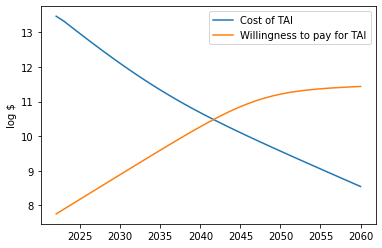

## RUN 22/10000 ##
Diagnostic: tai_flop_size=43.065595154362626, nonscaling_delay=11.045940340694864, algo_doubling_rate=4.4657288609289525, possible_algo_reduction=5.742208815208708, initial_flops_per_dollar=1.4883819139547885e+17, flops_halving_rate=2.558132709937837, max_flops_per_dollar=4.262607142446644e+23, initial_pay=39859312.69568133, gdp_growth=1.0264024819516864, max_gdp_frac=0.0034095054385882536, willingness_ramp=0.7333916626701933, spend_doubling_time=0.5
-
It takes 43.1 log FLOPs (10 billion decillion) for transformative capabilities.
Every 4.5 years algorithms get 2x better, with 5.7 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.6 years they get 2x cheaper, to a maximum of 23.6 log FLOPs (100 sextillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 0.5x per year to a max of 0.0034% of GDP. GDP grows at a rate of 1.026x per year.
If we are 73.0% of the way to paying for TAI, we will ramp to 

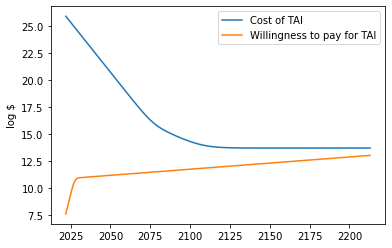

## RUN 23/10000 ##
Diagnostic: tai_flop_size=20.949049571358234, nonscaling_delay=29.619963307832496, algo_doubling_rate=1.6730306675831568, possible_algo_reduction=2.162911002123731, initial_flops_per_dollar=1.4969757559179008e+17, flops_halving_rate=2.8868209546288566, max_flops_per_dollar=3.305634341575964e+24, initial_pay=25513414.713931873, gdp_growth=1.0252655463439273, max_gdp_frac=0.0037065124880659574, willingness_ramp=0.9023188022269127, spend_doubling_time=1.3532826071466861
-
It takes 20.9 log FLOPs (100 quintillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 1.4x per year to a max of 0.0037% of GDP. GDP grows at a rate of 1.025x per year.
If we are 90.0% of the way to paying for TAI, we w

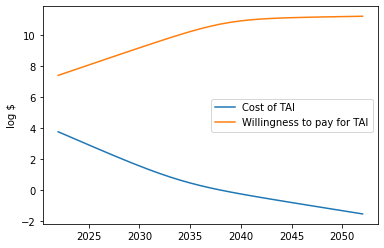

## RUN 24/10000 ##
Diagnostic: tai_flop_size=30.826768826333822, nonscaling_delay=4.465622566495768, algo_doubling_rate=1, possible_algo_reduction=2.4400695862406208, initial_flops_per_dollar=2.0536663047729728e+17, flops_halving_rate=2.5940695214033402, max_flops_per_dollar=1.6807364670330444e+22, initial_pay=40592731.97220098, gdp_growth=1.020856773346509, max_gdp_frac=0.004974507823500324, willingness_ramp=0.8824946314418908, spend_doubling_time=0.882197491918342
-
It takes 30.8 log FLOPs (one nonillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.6 years they get 2x cheaper, to a maximum of 22.2 log FLOPs (10 sextillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 0.9x per year to a max of 0.005% of GDP. GDP grows at a rate of 1.021x per year.
If we are 88.0% of the way to paying for TAI, we will ramp to paying for TAI

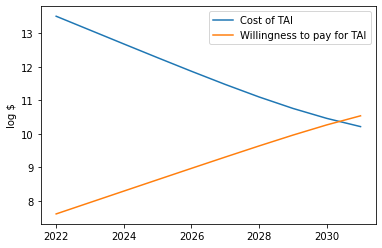

## RUN 25/10000 ##
Diagnostic: tai_flop_size=28.907941537021905, nonscaling_delay=1.8582840525384727, algo_doubling_rate=2.691011102567826, possible_algo_reduction=1.2503093024173695, initial_flops_per_dollar=2.015337612311969e+17, flops_halving_rate=2.3687969736537644, max_flops_per_dollar=3.7345148966053585e+23, initial_pay=57112798.846998475, gdp_growth=1.014241923151663, max_gdp_frac=0.0046224459745380485, willingness_ramp=0.8180436842883652, spend_doubling_time=1.0136353573243555
-
It takes 28.9 log FLOPs (10 octillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 1.3 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.4 years they get 2x cheaper, to a maximum of 23.6 log FLOPs (100 sextillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 1.0x per year to a max of 0.0046% of GDP. GDP grows at a rate of 1.014x per year.
If we are 82.0% of the way to paying for TAI, we will 

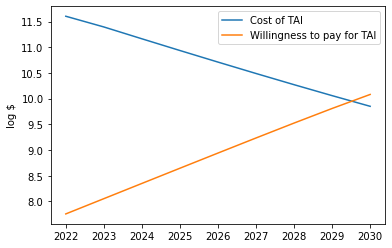

## RUN 26/10000 ##
Diagnostic: tai_flop_size=34.55127905467771, nonscaling_delay=19.40985116048659, algo_doubling_rate=1.8945479696889693, possible_algo_reduction=2.983251416734928, initial_flops_per_dollar=1.5105499817479158e+17, flops_halving_rate=3.472245721179233, max_flops_per_dollar=2.829952968764503e+22, initial_pay=9712429.407725371, gdp_growth=1.0232645514507477, max_gdp_frac=0.007761129806225926, willingness_ramp=0.8952560790828963, spend_doubling_time=1.124239168989929
-
It takes 34.6 log FLOPs (10 decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.5 years they get 2x cheaper, to a maximum of 22.5 log FLOPs (10 sextillion) per $.
We are willing to pay 7.0 log $ (one million) and this increases by 1.1x per year to a max of 0.0078% of GDP. GDP grows at a rate of 1.023x per year.
If we are 90.0% of the way to paying for TAI, we will ramp 

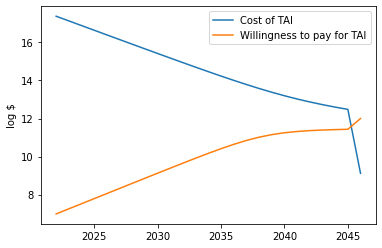

## RUN 27/10000 ##
Diagnostic: tai_flop_size=35.29419523248673, nonscaling_delay=1.4192731058461596, algo_doubling_rate=3.4463098674091466, possible_algo_reduction=3.3753726455839197, initial_flops_per_dollar=1.5767650753136195e+17, flops_halving_rate=2.9771968786433853, max_flops_per_dollar=1.339945378109796e+25, initial_pay=99624373.17050701, gdp_growth=1.0251542299062604, max_gdp_frac=0.010003821897951405, willingness_ramp=0.8930647935889081, spend_doubling_time=0.8483060208766323
-
It takes 35.3 log FLOPs (100 decillion) for transformative capabilities.
Every 3.4 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 25.1 log FLOPs (10 septillion) per $.
We are willing to pay 8.0 log $ (10 million) and this increases by 0.8x per year to a max of 0.01% of GDP. GDP grows at a rate of 1.025x per year.
If we are 89.0% of the way to paying for TAI, we will ram

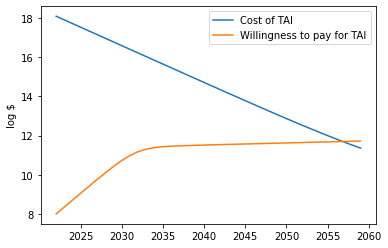

## RUN 28/10000 ##
Diagnostic: tai_flop_size=39.40144296987052, nonscaling_delay=2.057529518381175, algo_doubling_rate=4.206911135151065, possible_algo_reduction=4.387223630985483, initial_flops_per_dollar=2.4344419481790768e+17, flops_halving_rate=3.260834088739093, max_flops_per_dollar=4.182167159838329e+23, initial_pay=93330142.90771937, gdp_growth=1.0245148339337762, max_gdp_frac=0.006796003261593654, willingness_ramp=0.923442555485755, spend_doubling_time=1.9545200268018406
-
It takes 39.4 log FLOPs (one million decillion) for transformative capabilities.
Every 4.2 years algorithms get 2x better, with 4.4 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 23.6 log FLOPs (100 sextillion) per $.
We are willing to pay 8.0 log $ (10 million) and this increases by 2.0x per year to a max of 0.0068% of GDP. GDP grows at a rate of 1.025x per year.
If we are 92.0% of the way to paying for TAI, we wi

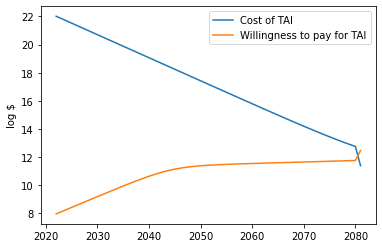

## RUN 29/10000 ##
Diagnostic: tai_flop_size=28.699068551054694, nonscaling_delay=2.0231264046291177, algo_doubling_rate=4.844155439341125, possible_algo_reduction=1.256051129060451, initial_flops_per_dollar=1.4222016713339426e+17, flops_halving_rate=2.851064195120516, max_flops_per_dollar=2.3578168055695263e+25, initial_pay=38797166.342774704, gdp_growth=1.0174871772096292, max_gdp_frac=0.03501710568683987, willingness_ramp=0.9576981987208215, spend_doubling_time=0.8245256667603357
-
It takes 28.7 log FLOPs (10 octillion) for transformative capabilities.
Every 4.8 years algorithms get 2x better, with 1.3 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 25.4 log FLOPs (10 septillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 0.8x per year to a max of 0.035% of GDP. GDP grows at a rate of 1.017x per year.
If we are 96.0% of the way to paying for TAI, we will ramp

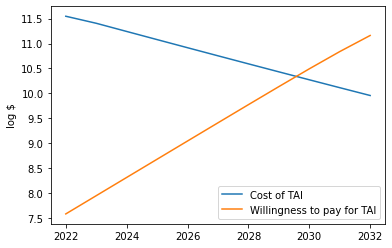

## RUN 30/10000 ##
Diagnostic: tai_flop_size=49.396750900644, nonscaling_delay=7.603403056218277, algo_doubling_rate=1.8011832766484315, possible_algo_reduction=6.201721964243616, initial_flops_per_dollar=2.1243130164436694e+17, flops_halving_rate=3.9429440438605736, max_flops_per_dollar=3.386354390555438e+27, initial_pay=29207681.788805243, gdp_growth=1.0192807277707427, max_gdp_frac=0.019533225421936824, willingness_ramp=0.9341061335745057, spend_doubling_time=0.5
-
It takes 49.4 log FLOPs (10 quadrillion decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 6.2 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.9 years they get 2x cheaper, to a maximum of 27.5 log FLOPs (one octillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.5x per year to a max of 0.0195% of GDP. GDP grows at a rate of 1.019x per year.
If we are 93.0% of the way to paying for TAI, we will ramp to 

--- no rapid recursive loop (ratio=0.0, p=0.0018385201660001149, r_=0.9791727906907899)
Year: 2145 - 39.3 max log FLOP (one million decillion) available - TAI takes 43.2 log FLOP (10 billion decillion) - log $ 16.5 to buy TAI (10 quadrillion) vs. willingness to pay log $ 12.6 (one trillion) - 26.7 log FLOPS per $ (100 septillion)
--- no rapid recursive loop (ratio=0.0, p=0.0018397523067162757, r_=0.15822933359437463)
Year: 2146 - 39.4 max log FLOP (one million decillion) available - TAI takes 43.2 log FLOP (10 billion decillion) - log $ 16.5 to buy TAI (10 quadrillion) vs. willingness to pay log $ 12.6 (one trillion) - 26.7 log FLOPS per $ (100 septillion)
--- no rapid recursive loop (ratio=0.0, p=0.0018411854003675793, r_=0.3725215178685858)
Year: 2147 - 39.4 max log FLOP (one million decillion) available - TAI takes 43.2 log FLOP (10 billion decillion) - log $ 16.4 to buy TAI (10 quadrillion) vs. willingness to pay log $ 12.6 (one trillion) - 26.8 log FLOPS per $ (100 septillion)
---

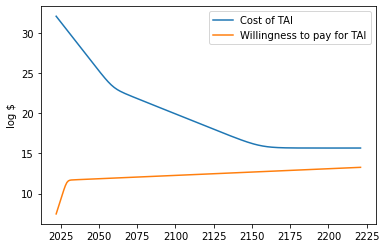

## RUN 101/10000 ##
## RUN 201/10000 ##
## RUN 301/10000 ##
## RUN 401/10000 ##
## RUN 501/10000 ##
## RUN 601/10000 ##
## RUN 701/10000 ##
## RUN 801/10000 ##
## RUN 901/10000 ##
## RUN 1001/10000 ##
## RUN 1101/10000 ##
## RUN 1201/10000 ##
## RUN 1301/10000 ##
## RUN 1401/10000 ##
## RUN 1501/10000 ##
## RUN 1601/10000 ##
## RUN 1701/10000 ##
## RUN 1801/10000 ##
## RUN 1901/10000 ##
## RUN 2001/10000 ##
## RUN 2101/10000 ##
## RUN 2201/10000 ##
## RUN 2301/10000 ##
## RUN 2401/10000 ##
## RUN 2501/10000 ##
## RUN 2601/10000 ##
## RUN 2701/10000 ##
## RUN 2801/10000 ##
## RUN 2901/10000 ##
## RUN 3001/10000 ##
## RUN 3101/10000 ##
## RUN 3201/10000 ##
## RUN 3301/10000 ##
## RUN 3401/10000 ##
## RUN 3501/10000 ##
## RUN 3601/10000 ##
## RUN 3701/10000 ##
## RUN 3801/10000 ##
## RUN 3901/10000 ##
## RUN 4001/10000 ##
## RUN 4101/10000 ##
## RUN 4201/10000 ##
## RUN 4301/10000 ##
## RUN 4401/10000 ##
## RUN 4501/10000 ##
## RUN 4601/10000 ##
## RUN 4701/10000 ##
## RUN 4801/10000 ##
#

In [139]:
tai_years = []
tai_flop_size_log_ = []
plt.ioff()
print('Running')

for r in range(RUNS):
    print_diagnostic = r < 30
    if print_diagnostic or r % 100 == 0 or r >= RUNS - 1:
        print('## RUN {}/{} ##'.format(r + 1, RUNS))
    if print_diagnostic:
        cost_of_tai_collector = []
        willingness_collector = []
    
    tai_flop_size_ = sample(tai_flop_size)
    tai_flop_size_log_.append(tai_flop_size_)
    algo_doubling_rate_ = sample(algo_doubling_rate)
    possible_algo_reduction_ = possible_algo_reduction_fn(sample(min_reduction),
                                                          sample(max_reduction),
                                                          tai_flop_size_)
    initial_flops_per_dollar_ = 10 ** sample(initial_flops_per_dollar)
    flops_halving_rate_ = sample(flops_halving_rate)
    max_flops_per_dollar_ = 10 ** sample(max_flops_per_dollar)
    initial_pay_ = 10 ** sample(initial_pay)
    gdp_growth_ = sample(gdp_growth)
    max_gdp_frac_ = sample(max_gdp_frac)
    willingness_ramp_ = sample(willingness_ramp)
    spend_doubling_time_ = sample(spend_doubling_time)
    nonscaling_delay_ = sample(nonscaling_delay)
    initial_chance_of_nonscaling_issue_ = initial_chance_of_nonscaling_issue
    final_chance_of_nonscaling_issue_ = final_chance_of_nonscaling_issue
    
    if print_diagnostic:
        diagnostic = 'Diagnostic: tai_flop_size={}, nonscaling_delay={}, algo_doubling_rate={}, '
        diagnostic += 'possible_algo_reduction={}, initial_flops_per_dollar={}, flops_halving_rate={}, '
        diagnostic += 'max_flops_per_dollar={}, initial_pay={}, gdp_growth={}, max_gdp_frac={}, '
        diagnostic += 'willingness_ramp={}, spend_doubling_time={}'
        print(diagnostic.format(tai_flop_size_, nonscaling_delay_, algo_doubling_rate_,
                                possible_algo_reduction_, initial_flops_per_dollar_, flops_halving_rate_,
                                max_flops_per_dollar_, initial_pay_, gdp_growth_, max_gdp_frac_,
                                willingness_ramp_, spend_doubling_time_))
        print('-')

        print('It takes {} log FLOPs ({}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                   numerize(tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs ({}) per $. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs ({}) per $.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                              numerize(math.log10(initial_flops_per_dollar_)),
                                                                              np.round(flops_halving_rate_, 1),
                                                                              np.round(math.log10(max_flops_per_dollar_), 1),
                                                                              numerize(math.log10(max_flops_per_dollar_))))
        print(('We are willing to pay {} log $ ({}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              numerize(math.log10(initial_pay_)),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 4),
                                                              np.round(gdp_growth_, 3)))
        print('If we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('---')
    
    tai_created = False
    is_nonscaling_issue = None
    recursive = False
    for y in years:
        if not tai_created:  
            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=(y - CURRENT_YEAR))
            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                
            cost_of_tai_ = flops_needed_ / flops_per_dollar_
            willingness_ = willingness_to_pay(initial_gdp=initial_gdp,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)
            
            total_compute_ = willingness_ * flops_per_dollar_
            p_recursive = p_rapid_recursive_self_improvement(flops_needed_,
                                                             total_compute_,
                                                             base_p_recursive,
                                                             recursive_curve_steepness,
                                                             recursive_curve_inflection)
            p_recursive = p_recursive / 8 # Attempt to turn CDF into PDF (approximation)
            
            cost_of_tai_collector.append(cost_of_tai_)
            willingness_collector.append(willingness_)
            
            if print_diagnostic:
                out_str = ('Year: {} - {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(y,
                                     np.round(math.log10(total_compute_), 1),
                                     numerize(math.log10(total_compute_)),
                                     np.round(math.log10(flops_needed_), 1),
                                     numerize(math.log10(flops_needed_)),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     numerize(math.log10(cost_of_tai_)),
                                     np.round(math.log10(willingness_), 1),
                                     numerize(math.log10(willingness_)),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     numerize(math.log10(flops_per_dollar_))))
            
            if cost_of_tai_ * willingness_ramp_ <= willingness_:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                             final_chance_of_nonscaling_issue,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year)
                    r_ = random.random()
                    is_nonscaling_issue = r_ < p_nonscaling_delay_
                    nonscaling_countdown = nonscaling_delay_
                    if print_diagnostic:
                        print('-- {} p_nonscaling_issue={} r_={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                         np.round(p_nonscaling_delay_, 4),
                                                                         np.round(r_, 4)))
                
                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if print_diagnostic:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                else:
                    if print_diagnostic:
                        print('/!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            
            r_ = random.random()
            if not tai_created and not is_nonscaling_issue and not recursive and r_ < p_recursive:
                flops_halving_rate__ = sample(recursive_flops_halving_rate)
                flops_halving_rate_ = flops_halving_rate__ if flops_halving_rate__ < flops_halving_rate_ else flops_halving_rate_
                algo_doubling_rate__ = sample(recursive_algo_doubling_rate)
                algo_doubling_rate_ = algo_doubling_rate__ if algo_doubling_rate__ < algo_doubling_rate_ else algo_doubling_rate_
                spend_doubling_time__ = sample(recursive_spend_doubling_time)
                spend_doubling_time_ = spend_doubling_time__ if spend_doubling_time__ < spend_doubling_time_ else spend_doubling_time_
                gdp_growth__ = sample(recursive_gdp_growth)
                gdp_growth_ = gdp_growth__ if gdp_growth__ > gdp_growth_ else gdp_growth_
                initial_chance_of_nonscaling_issue_ = recursive_initial_chance_of_nonscaling_issue
                final_chance_of_nonscaling_issue_ = recursive_final_chance_of_nonscaling_issue
                recursive = True
                # TODO: fix issue where this changes the variables as of 2022 rather than as of the time of the rapid recursion

                if print_diagnostic:
                    print(('--- rapid recursive loop (ratio={} p={}, r_={}) - set flops_having_rate={}, ' +
                           'algo_doubling_rate={} spend_doubling_time={}, gdp_growth={}, initial_chance_of_nonscaling_issue={} ' +
                           'final_chance_of_nonscaling_issue={}').format(total_compute_ / flops_needed_,
                                                                         p_recursive,
                                                                         r_,
                                                                         flops_halving_rate_,
                                                                         algo_doubling_rate_,
                                                                         spend_doubling_time_,
                                                                         gdp_growth_,
                                                                         initial_chance_of_nonscaling_issue,
                                                                         final_chance_of_nonscaling_issue))
                if event_occurs(p_recursive_creates_tai_instantly):
                    if print_diagnostic:
                        print('--- /!\ RRSI LOOP CREATES TAI in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                        
            elif not tai_created and not is_nonscaling_issue and not recursive and print_diagnostic:
                print('--- no rapid recursive loop (ratio={}, p={}, r_={})'.format(round(total_compute_ / flops_needed_, 3),
                                                                                   p_recursive,
                                                                                   r_))
                
    if not tai_created:
        if print_diagnostic:
            print('--- :/ TAI NOT CREATED BEFORE {}'.format(MAX_YEAR + 1))
            plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
        tai_years.append(MAX_YEAR + 1)


In [107]:
out = get_percentiles(tai_years)
[str(o[0]) + '%: ' + (str(int(o[1])) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR)) for o in out.items()]

# NOTE: Ajeya's numbers should output something very close to:
# '5%': 2027,
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2047',
# '50%: 2053',
# '60%: 2061',
# '70%: 2073',
# '80%: >2100',
# '90%: >2100',
# '95%: >2100'

# My latest numbers (2022 Jul 25 9:44PM CT):
#['5%: 2028',
# '10%: 2032',
# '20%: 2037',
# '30%: 2043',
# '40%: 2049',
# '50%: 2056',
# '60%: 2065',
# '70%: 2076',
# '80%: 2099',
# '90%: 2218',
# '95%: >2222']


['5%: 2028',
 '10%: 2032',
 '20%: 2037',
 '30%: 2043',
 '40%: 2049',
 '50%: 2056',
 '60%: 2065',
 '70%: 2077',
 '80%: 2099',
 '90%: 2218',
 '95%: >2222']

In [108]:
[str(o[0]) + '%: ' + (str(int(o[1]) - CURRENT_YEAR) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR - CURRENT_YEAR)) + ' years from now' for o in out.items()]


['5%: 6 years from now',
 '10%: 10 years from now',
 '20%: 15 years from now',
 '30%: 21 years from now',
 '40%: 27 years from now',
 '50%: 34 years from now',
 '60%: 43 years from now',
 '70%: 55 years from now',
 '80%: 77 years from now',
 '90%: 196 years from now',
 '95%: >200 years from now']

In [109]:
def print_chance_tai_by_year(data, year_target):
    return '{}% chance of TAI by EOY {}'.format(int(np.round(sum([1 if y <= year_target else 0 for y in data]) / len(data) * 100, 0)),
                                                year_target)
    
print('## Within <2 years')
print_chance_tai_by_year(tai_years, 2023)


## Within <2 years


'1% chance of TAI by EOY 2023'

In [110]:
print_chance_tai_by_year(tai_years, 2024)

'1% chance of TAI by EOY 2024'

In [111]:
print_chance_tai_by_year(tai_years, 2025)

'2% chance of TAI by EOY 2025'

In [112]:
print('## Within 5 years')
print_chance_tai_by_year(tai_years, 2027)

## Within 5 years


'4% chance of TAI by EOY 2027'

In [113]:
print_chance_tai_by_year(tai_years, 2029)

'6% chance of TAI by EOY 2029'

In [114]:
print_chance_tai_by_year(tai_years, 2030)

'8% chance of TAI by EOY 2030'

In [115]:
print('## Within 10 years')
print_chance_tai_by_year(tai_years, 2032)

## Within 10 years


'11% chance of TAI by EOY 2032'

In [116]:
# Holden benchmarks from https://www.cold-takes.com/biological-anchors-is-about-bounding-not-pinpointing-ai-timelines/#bio-anchors-as-a-way-of-bounding-ai-timelines
print('## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)')
print_chance_tai_by_year(tai_years, 2036)


## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)


'18% chance of TAI by EOY 2036'

In [117]:
print('## Within 15 years')
print_chance_tai_by_year(tai_years, 2037)

## Within 15 years


'20% chance of TAI by EOY 2037'

In [118]:
print_chance_tai_by_year(tai_years, 2039)

'24% chance of TAI by EOY 2039'

In [119]:
print('## Within 20 years')
print_chance_tai_by_year(tai_years, 2042)

## Within 20 years


'29% chance of TAI by EOY 2042'

In [120]:
print('## Within 25 years')
print_chance_tai_by_year(tai_years, 2047)

## Within 25 years


'37% chance of TAI by EOY 2047'

In [121]:
print_chance_tai_by_year(tai_years, 2049)

'40% chance of TAI by EOY 2049'

In [122]:
print_chance_tai_by_year(tai_years, 2059)

'54% chance of TAI by EOY 2059'

In [123]:
print('## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)')
print_chance_tai_by_year(tai_years, 2060)

## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)


'55% chance of TAI by EOY 2060'

In [124]:
print_chance_tai_by_year(tai_years, 2069)

'64% chance of TAI by EOY 2069'

In [125]:
print('## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)')
print_chance_tai_by_year(tai_years, 2070)

## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)


'65% chance of TAI by EOY 2070'

In [126]:
print('## Within 50 years')
print_chance_tai_by_year(tai_years, 2072)

## Within 50 years


'67% chance of TAI by EOY 2072'

In [127]:
print('## Within my personal expected lifespan')
print_chance_tai_by_year(tai_years, 2078)

## Within my personal expected lifespan


'71% chance of TAI by EOY 2078'

In [128]:
print('## Within 75 years')
print_chance_tai_by_year(tai_years, 2097)

## Within 75 years


'80% chance of TAI by EOY 2097'

In [129]:
print('## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)')
print_chance_tai_by_year(tai_years, 2100)

## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)


'81% chance of TAI by EOY 2100'

In [130]:
print('## Within 100 years')
print_chance_tai_by_year(tai_years, 2122)

## Within 100 years


'84% chance of TAI by EOY 2122'

In [131]:
print('## Within 200 years')
print_chance_tai_by_year(tai_years, 2222)

## Within 200 years


'90% chance of TAI by EOY 2222'

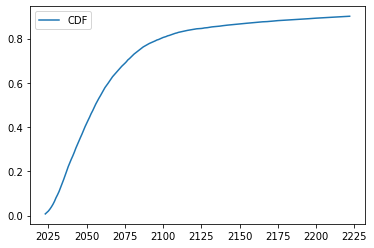

In [132]:
tai_years_ = np.array([MAX_YEAR + 1 if t > MAX_YEAR else t for t in tai_years])
count, bins_count = np.histogram(tai_years_, bins=(MAX_YEAR - CURRENT_YEAR))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
bins = np.round(np.array([b for b in bins_count[1:] if b <= MAX_YEAR]))

plt.plot(bins, cdf[:len(bins)], label='CDF')
plt.legend()

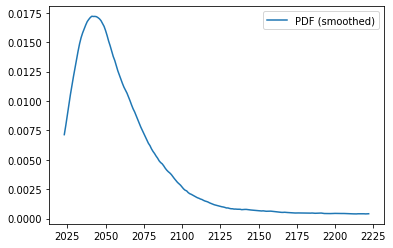

In [133]:
pdf_smoothed = savitzky_golay(pdf[:len(bins)], 51, 3) # window size 51, polynomial order 3
plt.plot(bins, pdf_smoothed, label='PDF (smoothed)')
plt.legend()
plt.show()

In [134]:
cdf[:len(bins)]

array([0.0073, 0.0134, 0.0201, 0.0288, 0.039 , 0.0505, 0.064 , 0.0803,
       0.0939, 0.1088, 0.1264, 0.1446, 0.1627, 0.1817, 0.2015, 0.2213,
       0.2382, 0.2547, 0.27  , 0.2868, 0.3051, 0.3214, 0.3378, 0.3531,
       0.3685, 0.3854, 0.4018, 0.4169, 0.4312, 0.4455, 0.4612, 0.4744,
       0.4893, 0.5041, 0.5169, 0.5297, 0.5414, 0.5541, 0.5673, 0.5785,
       0.5877, 0.5976, 0.608 , 0.6187, 0.628 , 0.6358, 0.6434, 0.6514,
       0.6591, 0.667 , 0.6751, 0.6814, 0.6883, 0.6954, 0.7039, 0.7096,
       0.7166, 0.7241, 0.73  , 0.7354, 0.7413, 0.7464, 0.7522, 0.7573,
       0.7624, 0.7663, 0.7707, 0.7744, 0.7781, 0.7811, 0.7843, 0.7872,
       0.7903, 0.7939, 0.7959, 0.799 , 0.8021, 0.8052, 0.8074, 0.8095,
       0.8127, 0.8144, 0.8168, 0.8197, 0.822 , 0.8242, 0.8258, 0.8283,
       0.8299, 0.8311, 0.8333, 0.8349, 0.8363, 0.8374, 0.8385, 0.8396,
       0.8408, 0.842 , 0.8431, 0.8445, 0.8452, 0.846 , 0.8469, 0.8484,
       0.849 , 0.8497, 0.8509, 0.8522, 0.8532, 0.8538, 0.8545, 0.8551,
      

In [135]:
pdf[:len(bins)]

array([0.0073, 0.0061, 0.0067, 0.0087, 0.0102, 0.0115, 0.0135, 0.0163,
       0.0136, 0.0149, 0.0176, 0.0182, 0.0181, 0.019 , 0.0198, 0.0198,
       0.0169, 0.0165, 0.0153, 0.0168, 0.0183, 0.0163, 0.0164, 0.0153,
       0.0154, 0.0169, 0.0164, 0.0151, 0.0143, 0.0143, 0.0157, 0.0132,
       0.0149, 0.0148, 0.0128, 0.0128, 0.0117, 0.0127, 0.0132, 0.0112,
       0.0092, 0.0099, 0.0104, 0.0107, 0.0093, 0.0078, 0.0076, 0.008 ,
       0.0077, 0.0079, 0.0081, 0.0063, 0.0069, 0.0071, 0.0085, 0.0057,
       0.007 , 0.0075, 0.0059, 0.0054, 0.0059, 0.0051, 0.0058, 0.0051,
       0.0051, 0.0039, 0.0044, 0.0037, 0.0037, 0.003 , 0.0032, 0.0029,
       0.0031, 0.0036, 0.002 , 0.0031, 0.0031, 0.0031, 0.0022, 0.0021,
       0.0032, 0.0017, 0.0024, 0.0029, 0.0023, 0.0022, 0.0016, 0.0025,
       0.0016, 0.0012, 0.0022, 0.0016, 0.0014, 0.0011, 0.0011, 0.0011,
       0.0012, 0.0012, 0.0011, 0.0014, 0.0007, 0.0008, 0.0009, 0.0015,
       0.0006, 0.0007, 0.0012, 0.0013, 0.001 , 0.0006, 0.0007, 0.0006,
      

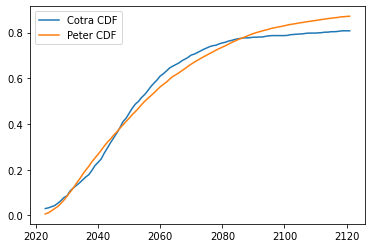

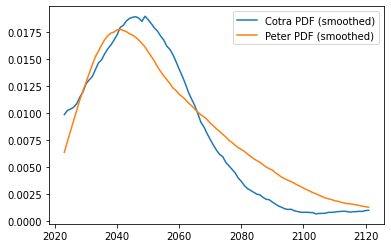

In [136]:
ajeya_cdf = [0.03 , 0.033, 0.038, 0.043, 0.053, 0.064, 0.078, 0.086, 0.107, 0.12 , 0.131, 0.142, 0.155, 0.168, 0.178,
             0.197, 0.218, 0.232, 0.247, 0.273, 0.295, 0.318, 0.339, 0.36 , 0.383, 0.41 , 0.425, 0.447, 0.469, 0.487,
             0.499, 0.516, 0.529, 0.546, 0.564, 0.579, 0.593, 0.61 , 0.62 , 0.632, 0.645, 0.653, 0.66 , 0.667, 0.677,
             0.684, 0.692, 0.702, 0.706, 0.713, 0.72 , 0.727, 0.733, 0.739, 0.743, 0.745, 0.751, 0.755, 0.758, 0.763,
             0.766, 0.77 , 0.773, 0.775, 0.777, 0.777, 0.778, 0.78 , 0.78 , 0.781, 0.781, 0.784, 0.786, 0.787, 0.787,
             0.787, 0.787, 0.787, 0.788, 0.791, 0.792, 0.793, 0.794, 0.795, 0.797, 0.798, 0.798, 0.798, 0.799, 0.8  ,
             0.802, 0.802, 0.804, 0.804, 0.805, 0.807, 0.808, 0.808, 0.808]
ajeya_pdf = np.append(np.array(ajeya_cdf[0]), np.diff(ajeya_cdf[:len(bins)]))
ajeya_pdf_smoothed = savitzky_golay(ajeya_pdf[:len(bins)], 51, 3)

peter_cdf = [0.0065, 0.0114, 0.0202, 0.0297, 0.0387, 0.0523, 0.0667, 0.0845,
       0.1022, 0.119 , 0.1403, 0.1584, 0.179 , 0.1977, 0.2148, 0.2347,
       0.251 , 0.2677, 0.285 , 0.3037, 0.3203, 0.3343, 0.351 , 0.365 ,
       0.3814, 0.3959, 0.4112, 0.4251, 0.4413, 0.4543, 0.469 , 0.4848,
       0.4993, 0.5118, 0.524 , 0.5363, 0.5497, 0.5629, 0.5734, 0.5835,
       0.5959, 0.6075, 0.6154, 0.6239, 0.6335, 0.6431, 0.6529, 0.6623,
       0.6707, 0.6789, 0.6869, 0.6944, 0.7018, 0.7091, 0.7158, 0.7236,
       0.7302, 0.7365, 0.7426, 0.7496, 0.757 , 0.7627, 0.7693, 0.7744,
       0.7798, 0.7851, 0.7908, 0.7959, 0.8002, 0.8042, 0.808 , 0.8117,
       0.8152, 0.8191, 0.8216, 0.8248, 0.8272, 0.83  , 0.8333, 0.836 ,
       0.8381, 0.8403, 0.8428, 0.8447, 0.8473, 0.849 , 0.8513, 0.8531,
       0.8552, 0.8574, 0.8593, 0.8615, 0.863 , 0.8649, 0.866 , 0.8685,
       0.8696, 0.8709, 0.8717, 0.8729, 0.8742, 0.875 , 0.8762, 0.877 ,
       0.8776, 0.8785, 0.8795, 0.8805, 0.8812, 0.8818, 0.8826, 0.8835,
       0.8847, 0.8853, 0.8858, 0.8869, 0.8874, 0.8876, 0.8882, 0.8888,
       0.8896, 0.8904, 0.891 , 0.8916, 0.8922, 0.8925, 0.8932, 0.8938,
       0.8943, 0.895 , 0.8959, 0.8967, 0.8974, 0.898 , 0.899 , 0.8996,
       0.9   , 0.9004, 0.9006, 0.9011, 0.9015, 0.9023, 0.9029, 0.9032,
       0.9039, 0.9041, 0.9045, 0.9048, 0.9052, 0.9057, 0.9061, 0.9064,
       0.9067, 0.907 , 0.9073, 0.9076, 0.908 , 0.9086, 0.9092, 0.91  ,
       0.9102, 0.9106, 0.9107, 0.911 , 0.9114, 0.9117, 0.9123, 0.9128,
       0.913 , 0.9133, 0.9136, 0.914 , 0.9143, 0.9145, 0.9151, 0.9155,
       0.9156, 0.916 , 0.9164, 0.9167, 0.9172, 0.9175, 0.918 , 0.9183,
       0.9189, 0.9195, 0.92  , 0.9202, 0.9204, 0.9206, 0.9208, 0.9212,
       0.9217, 0.9221, 0.9224, 0.9231, 0.9234, 0.9237, 0.9244]
peter_pdf = np.append(np.array(peter_cdf[0]), np.diff(peter_cdf[:len(bins)]))
peter_pdf_smoothed = savitzky_golay(peter_pdf[:len(bins)], 51, 3)

plt.plot(bins[:99], ajeya_cdf[:99], label='Cotra CDF')
plt.plot(bins[:99], peter_cdf[:99], label='Peter CDF')
plt.legend()
plt.show()

plt.plot(bins[:99], ajeya_pdf_smoothed[:99], label='Cotra PDF (smoothed)')
plt.plot(bins[:99], peter_pdf_smoothed[:99], label='Peter PDF (smoothed)')
plt.legend()
plt.show()